### US Accidents 資料分析：模型比較與時空風險預測
## 實驗設計
1. 比較有無資料前處理的影響
2. 比較有無混合採樣策略的影響
3. 使用三個模型：LightGBM, XGBoost, CatBoost（GPU加速版）
4. 包含交叉驗證和進度顯示
5. 創建時空風險預測數據供 Kepler.gl 使用

In [14]:
# ===========================
# Cell 1: 導入套件和設定
# ===========================
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import gc  # 垃圾回收
import torch
from tqdm import tqdm
warnings.filterwarnings('ignore')

# 基本套件
import os
import time
import joblib
import json
from collections import Counter

# Scikit-learn
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, 
    confusion_matrix, balanced_accuracy_score, 
    cohen_kappa_score, make_scorer
)
from sklearn.utils.class_weight import compute_class_weight

# 處理不平衡資料
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.ensemble import BalancedRandomForestClassifier

# Boosting模型
import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier, Pool  

# 檢查GPU
print("="*60)
print("環境檢查")
print("="*60)
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
print(f"XGBoost version: {xgb.__version__}")
print(f"LightGBM version: {lgb.__version__}")
print("="*60)

環境檢查
PyTorch version: 2.7.0+cu118
CUDA available: True
GPU: NVIDIA GeForce RTX 3090
GPU Memory: 23.56 GB
XGBoost version: 3.0.2
LightGBM version: 4.3.0


In [4]:
# ===========================
# Cell 2: 記憶體優化函數
# ===========================

def reduce_memory_usage(df, verbose=True):
    """通過改變數據類型來減少DataFrame的記憶體使用"""
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        print(f'記憶體使用減少了 {100 * (start_mem - end_mem) / start_mem:.1f}%')
        print(f'{start_mem:.2f} MB --> {end_mem:.2f} MB')
    
    return df

def clean_memory():
    """清理記憶體"""
    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()


In [5]:
# ===========================
# Cell 3: 載入資料（優化版）
# ===========================

def load_data_optimized(file_path, sample_frac=0.1):  # 使用10%資料做實驗
    """優化的資料載入"""
    print(f"\n載入資料: {file_path}")
    
    # 定義需要的欄位
    important_cols = [
        'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng',
        'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)',
        'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)',
        'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way',
        'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop',
        'Traffic_Calming', 'Traffic_Signal', 'Sunrise_Sunset', 'State'
    ]
    
    # 載入資料
    print(f"載入 {sample_frac*100}% 的資料...")
    df = pd.read_csv(file_path, usecols=lambda x: x in important_cols)
    df = df.sample(frac=sample_frac, random_state=42)
    
    print(f"載入資料大小: {df.shape}")
    print(f"記憶體使用: {df.memory_usage().sum() / 1024**2:.2f} MB")
    
    # 顯示目標變數分布
    print("\n目標變數分布:")
    severity_counts = df['Severity'].value_counts().sort_index()
    for sev, count in severity_counts.items():
        print(f"Severity {sev}: {count:,} ({count/len(df)*100:.2f}%)")
    
    return df

# 執行載入
file_path = 'us-accidents/US_Accidents_March23.csv'
df = load_data_optimized(file_path, sample_frac=0.1)


載入資料: us-accidents/US_Accidents_March23.csv
載入 10.0% 的資料...
載入資料大小: (772839, 27)
記憶體使用: 103.19 MB

目標變數分布:
Severity 1: 6,803 (0.88%)
Severity 2: 615,250 (79.61%)
Severity 3: 130,256 (16.85%)
Severity 4: 20,530 (2.66%)


In [6]:
# ===========================
# Cell 4: 基礎特徵工程函數
# ===========================

def basic_preprocessing(df):
    """基礎前處理：只處理缺失值和基本轉換"""
    df_copy = df.copy()
    
    # 處理日期時間
    df_copy['Start_Time'] = pd.to_datetime(df_copy['Start_Time'], errors='coerce')
    df_copy['End_Time'] = pd.to_datetime(df_copy['End_Time'], errors='coerce')
    
    # 計算持續時間
    df_copy['Duration_minutes'] = (df_copy['End_Time'] - df_copy['Start_Time']).dt.total_seconds() / 60
    
    # 過濾異常值
    df_copy = df_copy[(df_copy['Duration_minutes'] > 0) & (df_copy['Duration_minutes'] < 1440*7)]
    df_copy = df_copy.dropna(subset=['Start_Time'])
    
    # 提取基本時間特徵
    df_copy['Hour'] = df_copy['Start_Time'].dt.hour
    df_copy['DayOfWeek'] = df_copy['Start_Time'].dt.dayofweek
    df_copy['Month'] = df_copy['Start_Time'].dt.month
    
    # 處理缺失值（簡單填充）
    numeric_cols = df_copy.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if col != 'Severity':
            df_copy[col] = df_copy[col].fillna(df_copy[col].median())
    
    # 類別變數填充
    categorical_cols = ['Weather_Condition', 'State', 'Sunrise_Sunset']
    for col in categorical_cols:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].fillna('Unknown')
    
    # 布林型欄位轉換
    bool_cols = df_copy.select_dtypes(include=['bool']).columns
    for col in bool_cols:
        df_copy[col] = df_copy[col].astype(int)
    
    # 刪除不需要的欄位
    df_copy = df_copy.drop(['Start_Time', 'End_Time'], axis=1, errors='ignore')
    
    return df_copy

def advanced_preprocessing(df):
    """進階前處理：包含所有特徵工程"""
    df_copy = df.copy()
    
    # 先做基礎處理
    df_copy = basic_preprocessing(df_copy)
    
    # 額外的特徵工程
    # 1. 是否週末
    df_copy['IsWeekend'] = (df_copy['DayOfWeek'] >= 5).astype(int)
    
    # 2. 是否尖峰時段
    df_copy['IsRushHour'] = df_copy['Hour'].apply(
        lambda x: 1 if (6 <= x <= 9) or (16 <= x <= 19) else 0
    )
    
    # 3. 時段分類
    df_copy['TimeOfDay'] = pd.cut(df_copy['Hour'], 
                                  bins=[-1, 6, 12, 18, 24], 
                                  labels=[0, 1, 2, 3]).astype(int)
    
    # 4. 季節
    df_copy['Season'] = pd.cut(df_copy['Month'], 
                               bins=[0, 3, 6, 9, 12], 
                               labels=[0, 1, 2, 3]).astype(int)
    
    # 5. 天氣分類（如果有天氣條件）
    if 'Weather_Condition' in df_copy.columns:
        def categorize_weather(condition):
            if pd.isna(condition):
                return 0
            condition = str(condition).lower()
            if any(word in condition for word in ['clear', 'fair']):
                return 1
            elif any(word in condition for word in ['cloud', 'overcast']):
                return 2
            elif any(word in condition for word in ['rain', 'drizzle']):
                return 3
            elif any(word in condition for word in ['snow', 'sleet']):
                return 4
            elif any(word in condition for word in ['fog', 'mist']):
                return 5
            elif any(word in condition for word in ['storm', 'thunder']):
                return 6
            else:
                return 7
        
        df_copy['Weather_Category'] = df_copy['Weather_Condition'].apply(categorize_weather)
        df_copy = df_copy.drop('Weather_Condition', axis=1)
    
    # 6. 對類別變數進行標籤編碼
    label_encoders = {}
    categorical_cols = ['State', 'Sunrise_Sunset']
    for col in categorical_cols:
        if col in df_copy.columns:
            le = LabelEncoder()
            df_copy[col] = le.fit_transform(df_copy[col].astype(str))
            label_encoders[col] = le
    
    return df_copy, label_encoders

In [7]:
# ===========================
# Cell 5: 混合採樣策略
# ===========================

def apply_mixed_sampling(X_train, y_train):
    """應用混合採樣策略"""
    print("\n應用混合採樣策略...")
    
    # 計算各類別數量
    unique, counts = np.unique(y_train, return_counts=True)
    class_counts = dict(zip(unique, counts))
    print("原始分布:", class_counts)
    
    # 混合策略：對多數類欠採樣，對少數類過採樣
    median_count = int(np.median(counts))
    target_count = int(median_count * 1.5)
    
    # 第一步：欠採樣
    undersample_strategy = {}
    for cls, cnt in class_counts.items():
        if cnt > target_count:
            undersample_strategy[cls] = target_count
        else:
            undersample_strategy[cls] = cnt
    
    if len(undersample_strategy) > 0:
        rus = RandomUnderSampler(sampling_strategy=undersample_strategy, random_state=42)
        X_temp, y_temp = rus.fit_resample(X_train, y_train)
    else:
        X_temp, y_temp = X_train, y_train
    
    # 第二步：過採樣
    temp_unique, temp_counts = np.unique(y_temp, return_counts=True)
    temp_class_counts = dict(zip(temp_unique, temp_counts))
    
    oversample_strategy = {}
    for cls, cnt in temp_class_counts.items():
        if cnt < target_count:
            oversample_strategy[cls] = target_count
        else:
            oversample_strategy[cls] = cnt
    
    if len(oversample_strategy) > 0:
        ros = RandomOverSampler(sampling_strategy=oversample_strategy, random_state=42)
        X_resampled, y_resampled = ros.fit_resample(X_temp, y_temp)
    else:
        X_resampled, y_resampled = X_temp, y_temp
    
    # 顯示新分布
    unique_new, counts_new = np.unique(y_resampled, return_counts=True)
    print("採樣後分布:", dict(zip(unique_new, counts_new)))
    
    return X_resampled, y_resampled

In [22]:
# ===========================
# Cell 6: GPU加速的模型訓練函數
# ===========================

def train_lightgbm_gpu(X_train, X_test, y_train, y_test, X_val=None, y_val=None):
    """訓練LightGBM模型（GPU版本）"""
    params = {
        'objective': 'multiclass',
        'num_class': 4,
        'metric': 'multi_logloss',
        'boosting_type': 'gbdt',
        'num_leaves': 127,
        'max_depth': -1,
        'learning_rate': 0.05,
        'feature_fraction': 0.9,
        'bagging_fraction': 0.8,
        'bagging_freq': 5,
        'verbose': -1,
        'random_state': 42,
        'device': 'gpu',
        'gpu_platform_id': 0,
        'gpu_device_id': 0,
        'max_bin': 63,
        'gpu_use_dp': False,
        'num_threads': 0
    }
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_sets = [lgb.Dataset(X_test, label=y_test, reference=train_data)]
    
    if X_val is not None:
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)
        valid_sets.append(val_data)
    
    print("訓練 LightGBM (GPU)...")
    start_time = time.time()
    
    # 使用進度條回調
    model = lgb.train(
        params,
        train_data,
        valid_sets=valid_sets,
        num_boost_round=1000,
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(period=100)
        ]
    )
    
    train_time = time.time() - start_time
    
    # 預測
    y_pred = model.predict(X_test, num_iteration=model.best_iteration)
    y_pred = np.argmax(y_pred, axis=1)
    
    if X_val is not None:
        y_val_pred = model.predict(X_val, num_iteration=model.best_iteration)
        y_val_pred = np.argmax(y_val_pred, axis=1)
        val_acc = accuracy_score(y_val, y_val_pred)
        print(f"驗證集準確率: {val_acc:.4f}")
    
    return model, y_pred, train_time

def train_xgboost_gpu(X_train, X_test, y_train, y_test, X_val=None, y_val=None):
    """訓練XGBoost模型（GPU版本）"""
    params = {
        'objective': 'multi:softprob',
        'num_class': 4,
        'max_depth': 8,
        'learning_rate': 0.1,
        'n_estimators': 1000,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'min_child_weight': 1,
        'gamma': 0.1,
        'random_state': 42,
        'tree_method': 'gpu_hist',
        'predictor': 'gpu_predictor',
        'gpu_id': 0,
        'max_bin': 256,
        'eval_metric': ['mlogloss', 'merror']
    }
    
    eval_set = [(X_test, y_test)]
    if X_val is not None:
        eval_set.append((X_val, y_val))
    
    model = xgb.XGBClassifier(**params)
    
    print("訓練 XGBoost (GPU)...")
    start_time = time.time()
    
    # 訓練模型，顯示進度
    model.fit(
        X_train, y_train,
        eval_set=eval_set,
        # callbacks=[xgb.callback.EarlyStopping(rounds=50)],
        verbose=100
    )
    
    train_time = time.time() - start_time
    
    # 預測
    y_pred = model.predict(X_test)
    
    if X_val is not None:
        val_acc = accuracy_score(y_val, model.predict(X_val))
        print(f"驗證集準確率: {val_acc:.4f}")
    
    return model, y_pred, train_time

def train_catboost_gpu(X_train, X_test, y_train, y_test, X_val=None, y_val=None):
    """訓練CatBoost模型（GPU版本）"""
    params = {
        'iterations': 1000,
        'depth': 8,
        'learning_rate': 0.05,
        'loss_function': 'MultiClass',
        'eval_metric': 'TotalF1',
        'random_state': 42,
        'task_type': 'GPU',
        'devices': '0',
        'bootstrap_type': 'Bayesian',
        'bagging_temperature': 0.8,
        'od_type': 'Iter',
        'od_wait': 50,
        'gpu_ram_part': 0.95,
        'max_ctr_complexity': 4,
        'verbose': 100
    }
    
    pool_train = Pool(X_train, y_train)
    pool_test  = Pool(X_test,  y_test)
    
    model = CatBoostClassifier(**params)
    
    print("訓練 CatBoost (GPU)...")
    start_time = time.time()
    
    eval_set = pool_test
    if X_val is not None:
        pool_val = Pool(X_val, y_val)
        # eval_set = [pool_test, pool_val]
    
    # # 訓練模型
    model.fit(
        pool_train,
        eval_set=eval_set,
        early_stopping_rounds=50,
        plot=False
    )
    
    train_time = time.time() - start_time
    
    # 預測
    y_pred = model.predict(X_test)
    
    if X_val is not None:
        val_acc = accuracy_score(y_val, model.predict(X_val))
        print(f"驗證集準確率: {val_acc:.4f}")
    
    return model, y_pred, train_time


In [9]:
# ===========================
# Cell 7: 交叉驗證函數
# ===========================

def cross_validate_model(model_func, X, y, cv_folds=5):
    """執行交叉驗證"""
    print(f"\n執行 {cv_folds} 折交叉驗證...")
    
    skf = StratifiedKFold(n_splits=cv_folds, shuffle=True, random_state=42)
    cv_scores = {
        'accuracy': [],
        'f1_score': [],
        'balanced_accuracy': []
    }
    
    for fold, (train_idx, val_idx) in enumerate(tqdm(skf.split(X, y), total=cv_folds, desc="CV Progress")):
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        
        # 訓練模型
        model, y_pred, _ = model_func(X_train_cv, X_val_cv, y_train_cv, y_val_cv)
        
        # 計算指標
        cv_scores['accuracy'].append(accuracy_score(y_val_cv, y_pred))
        cv_scores['f1_score'].append(f1_score(y_val_cv, y_pred, average='weighted'))
        cv_scores['balanced_accuracy'].append(balanced_accuracy_score(y_val_cv, y_pred))
        
        # 清理GPU記憶體
        clean_memory()
    
    # 計算平均值和標準差
    results = {}
    for metric, scores in cv_scores.items():
        results[f'{metric}_mean'] = np.mean(scores)
        results[f'{metric}_std'] = np.std(scores)
        print(f"{metric}: {results[f'{metric}_mean']:.4f} (+/- {results[f'{metric}_std']:.4f})")
    
    return results

In [23]:
# ===========================
# Cell 8: 實驗執行（含驗證集）
# ===========================

def run_experiment_with_validation(df):
    """執行完整實驗（含驗證集）"""
    results = {}
    
    # 準備四種數據組合
    print("\n準備數據組合...")
    
    # 1. 基礎處理 + 無採樣
    df_basic = basic_preprocessing(df)
    df_basic = df_basic.dropna()
    df_basic = df_basic[df_basic['Severity'].isin([1, 2, 3, 4])]

    # >>> 這三行是新的 (把 object → category → int)
    obj_cols = df_basic.select_dtypes(include='object').columns
    df_basic[obj_cols] = df_basic[obj_cols].astype('category').apply(lambda s: s.cat.codes)
    # <<<
    
    X_basic = df_basic.drop('Severity', axis=1).values
    y_basic = df_basic['Severity'].values - 1
    
    # 分割數據：60% 訓練, 20% 驗證, 20% 測試
    X_temp, X_test_basic, y_temp, y_test_basic = train_test_split(
        X_basic, y_basic, test_size=0.2, random_state=42, stratify=y_basic
    )
    X_train_basic, X_val_basic, y_train_basic, y_val_basic = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )
    
    # 2. 基礎處理 + 有採樣
    X_train_basic_sampled, y_train_basic_sampled = apply_mixed_sampling(X_train_basic, y_train_basic)
    
    # 3. 進階處理 + 無採樣
    df_advanced, _ = advanced_preprocessing(df)
    df_advanced = df_advanced.dropna()
    df_advanced = df_advanced[df_advanced['Severity'].isin([1, 2, 3, 4])]

    # >>> 同樣三行貼在這裡
    obj_cols = df_advanced.select_dtypes(include='object').columns
    df_advanced[obj_cols] = df_advanced[obj_cols].astype('category').apply(lambda s: s.cat.codes)
    # <<<
    
    X_advanced = df_advanced.drop('Severity', axis=1).values
    y_advanced = df_advanced['Severity'].values - 1
    
    X_temp, X_test_advanced, y_temp, y_test_advanced = train_test_split(
        X_advanced, y_advanced, test_size=0.2, random_state=42, stratify=y_advanced
    )
    X_train_advanced, X_val_advanced, y_train_advanced, y_val_advanced = train_test_split(
        X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
    )
    
    # 4. 進階處理 + 有採樣
    X_train_advanced_sampled, y_train_advanced_sampled = apply_mixed_sampling(X_train_advanced, y_train_advanced)
    
    # 定義實驗組合
    experiments = [
        ("基礎處理_無採樣", X_train_basic, X_test_basic, y_train_basic, y_test_basic, X_val_basic, y_val_basic),
        ("基礎處理_有採樣", X_train_basic_sampled, X_test_basic, y_train_basic_sampled, y_test_basic, X_val_basic, y_val_basic),
        ("進階處理_無採樣", X_train_advanced, X_test_advanced, y_train_advanced, y_test_advanced, X_val_advanced, y_val_advanced),
        ("進階處理_有採樣", X_train_advanced_sampled, X_test_advanced, y_train_advanced_sampled, y_test_advanced, X_val_advanced, y_val_advanced)
    ]
    
    # 執行實驗
    for exp_name, X_train, X_test, y_train, y_test, X_val, y_val in experiments:
        print(f"\n{'='*60}")
        print(f"實驗: {exp_name}")
        print(f"{'='*60}")
        print(f"訓練集大小: {X_train.shape}")
        print(f"驗證集大小: {X_val.shape}")
        print(f"測試集大小: {X_test.shape}")
        
        results[exp_name] = {}
        
        # LightGBM
        print("\n" + "-"*40)
        lgb_model, lgb_pred, lgb_time = train_lightgbm_gpu(X_train, X_test, y_train, y_test, X_val, y_val)
        lgb_acc = accuracy_score(y_test, lgb_pred)
        lgb_f1 = f1_score(y_test, lgb_pred, average='weighted')
        lgb_balanced_acc = balanced_accuracy_score(y_test, lgb_pred)
        
        results[exp_name]['LightGBM'] = {
            'accuracy': lgb_acc,
            'f1_score': lgb_f1,
            'balanced_accuracy': lgb_balanced_acc,
            'training_time': lgb_time,
            'model': lgb_model
        }
        print(f"測試集 - 準確率: {lgb_acc:.4f}, F1: {lgb_f1:.4f}, 平衡準確率: {lgb_balanced_acc:.4f}")
        clean_memory()
        
        # XGBoost
        print("\n" + "-"*40)
        xgb_model, xgb_pred, xgb_time = train_xgboost_gpu(X_train, X_test, y_train, y_test, X_val, y_val)
        xgb_acc = accuracy_score(y_test, xgb_pred)
        xgb_f1 = f1_score(y_test, xgb_pred, average='weighted')
        xgb_balanced_acc = balanced_accuracy_score(y_test, xgb_pred)
        
        results[exp_name]['XGBoost'] = {
            'accuracy': xgb_acc,
            'f1_score': xgb_f1,
            'balanced_accuracy': xgb_balanced_acc,
            'training_time': xgb_time,
            'model': xgb_model
        }
        print(f"測試集 - 準確率: {xgb_acc:.4f}, F1: {xgb_f1:.4f}, 平衡準確率: {xgb_balanced_acc:.4f}")
        clean_memory()
        
        # CatBoost
        print("\n" + "-"*40)
        import catboost
        cat_model, cat_pred, cat_time = train_catboost_gpu(X_train, X_test, y_train, y_test, X_val, y_val)
        cat_acc = accuracy_score(y_test, cat_pred)
        cat_f1 = f1_score(y_test, cat_pred, average='weighted')
        cat_balanced_acc = balanced_accuracy_score(y_test, cat_pred)
        
        results[exp_name]['CatBoost'] = {
            'accuracy': cat_acc,
            'f1_score': cat_f1,
            'balanced_accuracy': cat_balanced_acc,
            'training_time': cat_time,
            'model': cat_model
        }
        print(f"測試集 - 準確率: {cat_acc:.4f}, F1: {cat_f1:.4f}, 平衡準確率: {cat_balanced_acc:.4f}")
        clean_memory()
    
    return results, df_advanced

# 執行實驗
print("\n開始執行實驗（含驗證集）...")
results, df_processed = run_experiment_with_validation(df)


開始執行實驗（含驗證集）...

準備數據組合...

應用混合採樣策略...
原始分布: {0: 4082, 1: 368806, 2: 78145, 3: 12253}
採樣後分布: {0: 67798, 1: 67798, 2: 67798, 3: 67798}

應用混合採樣策略...
原始分布: {0: 4082, 1: 368806, 2: 78145, 3: 12253}
採樣後分布: {0: 67798, 1: 67798, 2: 67798, 3: 67798}

實驗: 基礎處理_無採樣
訓練集大小: (463286, 28)
驗證集大小: (154429, 28)
測試集大小: (154429, 28)

----------------------------------------
訓練 LightGBM (GPU)...
Training until validation scores don't improve for 50 rounds
[100]	valid_0's multi_logloss: 0.371784	valid_1's multi_logloss: 0.369923
[200]	valid_0's multi_logloss: 0.363387	valid_1's multi_logloss: 0.361669
[300]	valid_0's multi_logloss: 0.360387	valid_1's multi_logloss: 0.35871
[400]	valid_0's multi_logloss: 0.358287	valid_1's multi_logloss: 0.3567
[500]	valid_0's multi_logloss: 0.357556	valid_1's multi_logloss: 0.355992
[600]	valid_0's multi_logloss: 0.35717	valid_1's multi_logloss: 0.355571
Early stopping, best iteration is:
[598]	valid_0's multi_logloss: 0.357155	valid_1's multi_logloss: 0.355573
驗證集準確率: 0

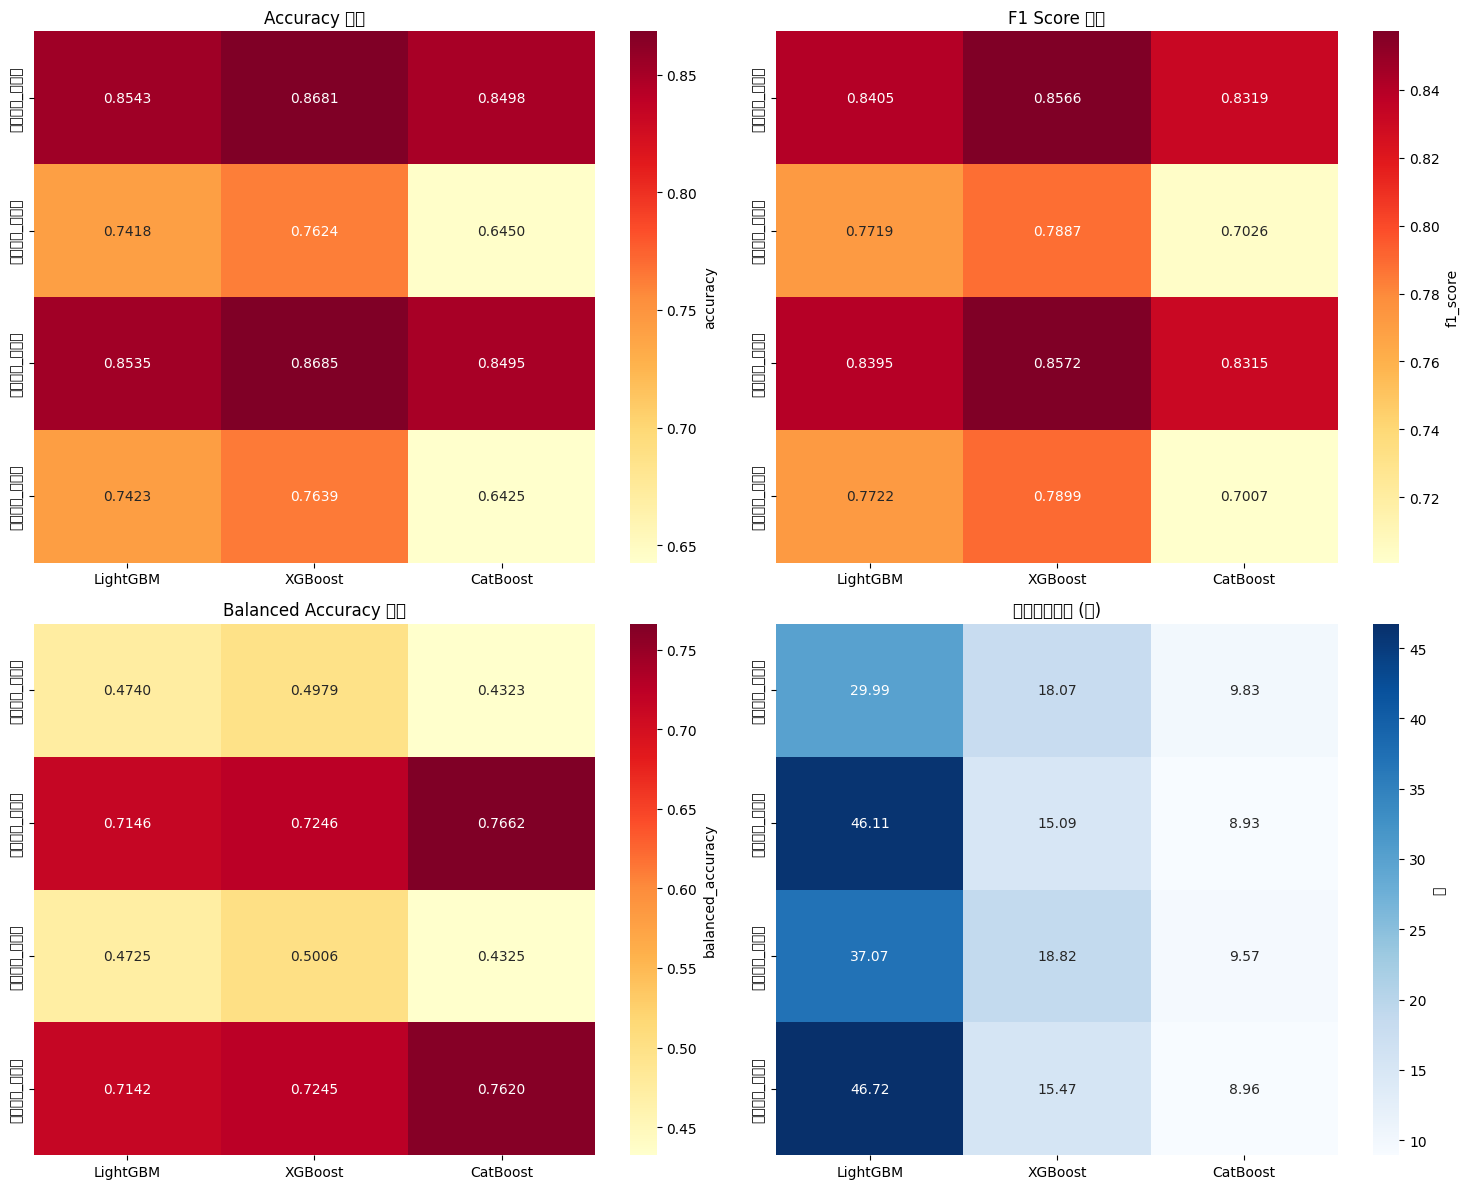


實驗結果總結
實驗                   模型         準確率        F1分數       平衡準確率        訓練時間(秒)     
----------------------------------------------------------------------------------------------------
基礎處理_無採樣             LightGBM   0.8543     0.8405     0.4740       29.99       
基礎處理_無採樣             XGBoost    0.8681     0.8566     0.4979       18.07       
基礎處理_無採樣             CatBoost   0.8498     0.8319     0.4323       9.83        
基礎處理_有採樣             LightGBM   0.7418     0.7719     0.7146       46.11       
基礎處理_有採樣             XGBoost    0.7624     0.7887     0.7246       15.09       
基礎處理_有採樣             CatBoost   0.6450     0.7026     0.7662       8.93        
進階處理_無採樣             LightGBM   0.8535     0.8395     0.4725       37.07       
進階處理_無採樣             XGBoost    0.8685     0.8572     0.5006       18.82       
進階處理_無採樣             CatBoost   0.8495     0.8315     0.4325       9.57        
進階處理_有採樣             LightGBM   0.7423     0.7722     0.7142       46.72       
進階處理_有採樣   

In [24]:
# ===========================
# Cell 9: 結果視覺化
# ===========================

def visualize_results(results):
    """視覺化實驗結果"""
    # 準備數據
    metrics = ['accuracy', 'f1_score', 'balanced_accuracy']
    models = ['LightGBM', 'XGBoost', 'CatBoost']
    experiments = list(results.keys())
    
    # 創建比較圖表
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.flatten()
    
    for idx, metric in enumerate(metrics):
        ax = axes[idx]
        
        # 準備數據
        data = []
        for exp in experiments:
            row = []
            for model in models:
                row.append(results[exp][model][metric])
            data.append(row)
        
        # 繪製熱力圖
        sns.heatmap(data, annot=True, fmt='.4f', 
                   xticklabels=models, yticklabels=experiments,
                   cmap='YlOrRd', ax=ax, cbar_kws={'label': metric})
        ax.set_title(f'{metric.replace("_", " ").title()} 比較')
    
    # 訓練時間比較
    ax = axes[3]
    time_data = []
    for exp in experiments:
        row = []
        for model in models:
            row.append(results[exp][model]['training_time'])
        time_data.append(row)
    
    sns.heatmap(time_data, annot=True, fmt='.2f', 
               xticklabels=models, yticklabels=experiments,
               cmap='Blues', ax=ax, cbar_kws={'label': '秒'})
    ax.set_title('訓練時間比較 (秒)')
    
    plt.tight_layout()
    plt.savefig('model_comparison_results.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # 打印總結表格
    print("\n" + "="*100)
    print("實驗結果總結")
    print("="*100)
    print(f"{'實驗':<20} {'模型':<10} {'準確率':<10} {'F1分數':<10} {'平衡準確率':<12} {'訓練時間(秒)':<12}")
    print("-"*100)
    
    for exp in experiments:
        for model in models:
            metrics = results[exp][model]
            print(f"{exp:<20} {model:<10} {metrics['accuracy']:<10.4f} "
                  f"{metrics['f1_score']:<10.4f} {metrics['balanced_accuracy']:<12.4f} "
                  f"{metrics['training_time']:<12.2f}")
    
    # 找出最佳組合
    best_score = 0
    best_combo = None
    for exp in experiments:
        for model in models:
            score = results[exp][model]['balanced_accuracy']
            if score > best_score:
                best_score = score
                best_combo = (exp, model)
    
    print(f"\n最佳組合: {best_combo[0]} - {best_combo[1]}")
    print(f"平衡準確率: {best_score:.4f}")
    
    return best_combo

best_combo = visualize_results(results)


In [26]:
# ===========================
# Cell 10: 準備 Kepler.gl 時空預測數據
# ===========================

print("\n" + "="*80)
print("準備 Kepler.gl 時空預測數據")
print("="*80)

# 重新載入包含地理位置的數據
print("\n載入地理數據...")
geo_cols = ['Start_Lat', 'Start_Lng', 'Start_Time', 'Severity', 'State', 'City',
            'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Weather_Condition',
            'Sunrise_Sunset']

# 為了演示，載入較小的數據集
df_geo = pd.read_csv(file_path, usecols=lambda x: x in geo_cols, nrows=100000)
df_geo['Start_Time'] = pd.to_datetime(df_geo['Start_Time'])
df_geo = df_geo.dropna(subset=['Start_Lat', 'Start_Lng'])

# 處理地理數據
df_geo['Hour'] = df_geo['Start_Time'].dt.hour
df_geo['DayOfWeek'] = df_geo['Start_Time'].dt.dayofweek
df_geo['Date'] = df_geo['Start_Time'].dt.date

print(f"地理數據大小: {df_geo.shape}")

# 使用最佳模型進行預測
print("\n使用最佳模型生成風險預測...")
best_exp, best_model_name = best_combo
best_model_obj = results[best_exp][best_model_name]['model']

# 準備預測數據（創建未來一週的預測）
def create_future_predictions(df_geo, model, model_name, days_ahead=7):
    """創建未來預測數據"""
    predictions = []
    
    # 獲取最新日期
    latest_date = df_geo['Date'].max()
    
    # 為每個地點創建未來預測
    locations = df_geo.groupby(['Start_Lat', 'Start_Lng']).size().reset_index(name='count')
    # 只選擇事故較多的地點
    locations = locations[locations['count'] >= 5].head(100)
    
    print(f"\n為 {len(locations)} 個高風險地點生成預測...")
    
    for _, loc in tqdm(locations.iterrows(), total=len(locations), desc="生成預測"):
        lat, lng = loc['Start_Lat'], loc['Start_Lng']
        
        # 獲取該地點的歷史數據
        loc_data = df_geo[(df_geo['Start_Lat'] == lat) & (df_geo['Start_Lng'] == lng)]
        
        # 為未來每天的每個時段創建預測
        for day_offset in range(days_ahead):
            future_date = latest_date + timedelta(days=day_offset + 1)
            
            for hour in [0, 6, 12, 18]:  # 每6小時一個預測
                # 創建簡化的特徵（根據您的模型需要調整）
                features_dict = {
                    'Hour': hour,
                    'DayOfWeek': future_date.weekday(),
                    'Month': future_date.month,
                    'Temperature(F)': loc_data['Temperature(F)'].mean() if 'Temperature(F)' in loc_data else 70,
                    'Humidity(%)': loc_data['Humidity(%)'].mean() if 'Humidity(%)' in loc_data else 50,
                    'Visibility(mi)': loc_data['Visibility(mi)'].mean() if 'Visibility(mi)' in loc_data else 10,
                }
                
                # 根據模型類型準備特徵
                if model_name == 'LightGBM':
                    # LightGBM 需要 numpy array
                    features = np.array([list(features_dict.values())])
                    pred_proba = model.predict(features, num_iteration=model.best_iteration)
                    risk_score = np.max(pred_proba[0])
                elif model_name == 'XGBoost':
                    features = np.array([list(features_dict.values())])
                    pred_proba = model.predict_proba(features)
                    risk_score = np.max(pred_proba[0])
                else:  # CatBoost
                    features = np.array([list(features_dict.values())])
                    pred_proba = model.predict_proba(features)
                    risk_score = np.max(pred_proba[0])
                
                prediction = {
                    'lat': lat,
                    'lng': lng,
                    'hour': hour,
                    'day_of_week': future_date.weekday(),
                    'date': future_date,
                    'timestamp': pd.Timestamp.combine(future_date, pd.Timestamp(f"{hour:02d}:00:00").time()),
                    'predicted_risk': risk_score,
                    'risk_level': 'High' if risk_score > 0.7 else 'Medium' if risk_score > 0.4 else 'Low',
                    'is_weekend': 1 if future_date.weekday() >= 5 else 0,
                    'is_rush_hour': 1 if (6 <= hour <= 9) or (16 <= hour <= 19) else 0,
                    'historical_severity': loc_data['Severity'].mean(),
                    'location_accident_count': len(loc_data)
                }
                
                predictions.append(prediction)
    
    return pd.DataFrame(predictions)

# 生成預測數據
future_predictions = create_future_predictions(df_geo, best_model_obj, best_model_name)

# 準備歷史數據（用於對比）
print("\n準備歷史數據...")
historical_data = df_geo.groupby(['Start_Lat', 'Start_Lng', 'Date', 'Hour']).agg({
    'Severity': ['count', 'mean']
}).reset_index()
historical_data.columns = ['lat', 'lng', 'date', 'hour', 'accident_count', 'avg_severity']
historical_data['timestamp'] = pd.to_datetime(historical_data['date'].astype(str) + ' ' + 
                                             historical_data['hour'].astype(str) + ':00:00')
historical_data['type'] = 'historical'

# 合併數據
future_predictions['type'] = 'prediction'
kepler_data = pd.concat([
    historical_data[['lat', 'lng', 'timestamp', 'accident_count', 'avg_severity', 'type']].rename(
        columns={'accident_count': 'value', 'avg_severity': 'risk_score'}
    ),
    future_predictions[['lat', 'lng', 'timestamp', 'predicted_risk', 'risk_level', 'type']].rename(
        columns={'predicted_risk': 'risk_score', 'risk_level': 'category'}
    )
], ignore_index=True, sort=False)

# 填充缺失值
kepler_data['value'] = kepler_data['value'].fillna(0)
kepler_data['category'] = kepler_data['category'].fillna('Unknown')

# 保存為 CSV
output_file = 'us_accidents_kepler_data.csv'
kepler_data.to_csv(output_file, index=False)
print(f"\n數據已保存至: {output_file}")
print(f"數據大小: {kepler_data.shape}")
print(f"時間範圍: {kepler_data['timestamp'].min()} 到 {kepler_data['timestamp'].max()}")


準備 Kepler.gl 時空預測數據

載入地理數據...
地理數據大小: (100000, 14)

使用最佳模型生成風險預測...

為 100 個高風險地點生成預測...


生成預測:   0%|          | 0/100 [00:00<?, ?it/s]


CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:72: Feature 6 is present in model but not in pool.

In [ ]:
# ===========================
# Cell 11: Kepler.gl 使用教學
# ===========================

print("\n" + "="*80)
print("Kepler.gl 使用教學")
print("="*80)

instructions = """
### 如何使用 Kepler.gl 視覺化您的數據：

1. **訪問 Kepler.gl**
   - 打開瀏覽器，訪問: https://kepler.gl/
   - 或使用 Kepler.gl 的 Jupyter 擴展（如果已安裝）

2. **上傳數據**
   - 點擊 "Add Data" 或直接拖拽 'us_accidents_kepler_data.csv' 文件到網頁上
   - 等待數據載入完成

3. **配置地圖圖層**
   建議創建以下圖層來展示不同維度的數據：

   a) **點圖層 (Point Layer) - 歷史事故**
      - Filter: type = 'historical'
      - Color: 根據 risk_score (使用紅色漸變)
      - Size: 根據 value (事故數量)
      - Radius: 5-10 pixels
      
   b) **熱力圖層 (Heatmap Layer) - 風險熱點**
      - 使用所有數據點
      - Radius: 20-30 km
      - Weight: risk_score
      - Intensity: 1-3
      
   c) **六邊形圖層 (Hexagon Layer) - 預測風險聚合**
      - Filter: type = 'prediction'
      - Height: 基於 risk_score 總和
      - Color: 使用紅黃綠漸變
      - Radius: 5-10 km

   d) **弧線圖層 (Arc Layer) - 風險傳播路徑**（可選）
      - 連接高風險區域
      - 顏色表示風險等級

4. **配置時間動畫**
   - 點擊左側面板的 "Filters"
   - 添加 timestamp 過濾器
   - 啟用時間動畫播放（點擊播放按鈕）
   - 調整播放速度和時間窗口

5. **互動功能**
   - 懸停查看詳細信息
   - 點擊數據點查看完整屬性
   - 使用圖層可見性開關比較不同視圖
   - 調整透明度查看重疊區域

6. **3D 視覺化**
   - 點擊右上角的 3D 按鈕
   - 使用滑鼠拖動旋轉視角
   - 滾輪縮放

7. **導出和分享**
   - 配置完成後，點擊 "Export Map"
   - 選擇 "Export as HTML" 生成獨立網頁
   - 或選擇 "Export Config" 保存配置文件

### 數據欄位說明：
- **lat, lng**: 地理座標
- **timestamp**: 時間戳（用於時間動畫）
- **type**: 數據類型（historical=歷史數據, prediction=預測數據）
- **value**: 歷史事故數量
- **risk_score**: 風險分數（0-1）
- **category**: 風險等級（High/Medium/Low）

### 進階技巧：
1. **多層疊加**：同時顯示歷史和預測數據，使用不同顏色區分
2. **時間比較**：使用分屏功能比較不同時期的風險分布
3. **自定義配色**：根據風險等級使用自定義顏色方案
4. **數據過濾**：結合多個過濾器查看特定條件下的風險模式
5. **地理圍欄**：繪製多邊形關注特定區域

### GPU 加速提示：
- Kepler.gl 會自動使用 WebGL 進行 GPU 加速渲染
- 如果數據量大，可以調整 "Resolution" 降低渲染精度提升性能
"""

print(instructions)

# 顯示數據預覽和統計
print("\n數據預覽：")
print(kepler_data.head(10))

print(f"\n數據統計：")
print(f"- 總數據點: {len(kepler_data):,}")
print(f"- 歷史數據: {len(kepler_data[kepler_data['type'] == 'historical']):,}")
print(f"- 預測數據: {len(kepler_data[kepler_data['type'] == 'prediction']):,}")
print(f"- 唯一位置數: {kepler_data[['lat', 'lng']].drop_duplicates().shape[0]:,}")
print(f"- 高風險預測點: {len(kepler_data[(kepler_data['type'] == 'prediction') & (kepler_data['category'] == 'High')]):,}")

# 顯示GPU使用情況
if torch.cuda.is_available():
    print(f"\nGPU 記憶體使用: {torch.cuda.memory_allocated() / 1024**3:.2f} GB")
    print(f"GPU 記憶體快取: {torch.cuda.memory_reserved() / 1024**3:.2f} GB")

print("\n實驗完成！請查看生成的文件和圖表。")

In [ ]:
# ===========================
# Cell 12: 選擇性執行交叉驗證
# ===========================

# 如果需要執行交叉驗證，取消以下註釋
"""
print("\n" + "="*80)
print("執行交叉驗證（可選）")
print("="*80)

# 選擇最佳配置進行交叉驗證
best_exp_name, best_model_name = best_combo

if best_exp_name.endswith("有採樣"):
    # 使用採樣後的數據
    if "進階" in best_exp_name:
        X_cv = X_train_advanced_sampled
        y_cv = y_train_advanced_sampled
    else:
        X_cv = X_train_basic_sampled
        y_cv = y_train_basic_sampled
else:
    # 使用原始數據
    if "進階" in best_exp_name:
        X_cv = X_train_advanced
        y_cv = y_train_advanced
    else:
        X_cv = X_train_basic
        y_cv = y_train_basic

# 選擇對應的模型函數
model_funcs = {
    'LightGBM': train_lightgbm_gpu,
    'XGBoost': train_xgboost_gpu,
    'CatBoost': train_catboost_gpu
}

print(f"\n對最佳組合進行交叉驗證: {best_exp_name} - {best_model_name}")
cv_results = cross_validate_model(model_funcs[best_model_name], X_cv, y_cv, cv_folds=5)
"""

print("\n所有任務完成！")